In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
# load data
def load_data():
    working_folder = ".."
    data_folder = "data"
    format1_fdir = 'data_format1_20180930_20181007.h5'#data_format1_201808.h5'#923_20180930.h5'#
    format2_fdir = 'data_format2_20180930_20181007.h5'#data_format2_201808.h5'#923_20180930.h5'#

    format1_dir = os.path.join(working_folder, data_folder, format1_fdir)
    format2_dir = os.path.join(working_folder, data_folder, format2_fdir)

    sys.path.append(working_folder)

    f1_data = pd.HDFStore(format1_dir)
    f1_data.keys()
    keys = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
    series_avg = pd.DataFrame()
    for key in keys:
        series_avg[key] = (0.25 * (f1_data[key]['close'] + f1_data[key]['open'] + f1_data[key]['high'] + f1_data[key]['low']))
    f1_data.close()
    return series_avg, keys

In [3]:
# define func
def train_test_split_self(data_x, data_y, test_size=0.33):
    size = len(data_x)
    train_size = int(len(data_x) * test_size)
    return data_x[:train_size], data_x[train_size:], data_y[:train_size], data_y[train_size:]

In [16]:
# train model
def train_model(data_x, data_y, is_plot:bool=False, is_print:bool=False):
    
    X_train, X_test, y_train, y_test = train_test_split_self(data_x, data_y, test_size=0.33)#, random_state=42)

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    # The mean squared error
    mse = mean_squared_error(y_test, y_pred)
    # Explained variance score: 1 is perfect prediction
    score = r2_score(y_test, y_pred)

    if is_print:
        print("Mean squared error: %.2f" % mse)
        print('Variance score: %.2f' % score)
         # The coefficients
        print('Coefficients: \n', regr.coef_)
        print('Intercept: \n', regr.intercept_)

    # Plot outputs
    if is_plot:
        fig = plt.figure(figsize=(20,10))
        x_axis = np.arange(len(X_test))
        plt.scatter(x_axis,y_test,  color='black')
        plt.plot(x_axis, y_pred, color='blue', linewidth=3)

        plt.xticks(())
        plt.yticks(())

        plt.show()
    
    
    return regr, {'mse':mse, 'score':score}

In [38]:
# load data
series_avg, keys = load_data()
# train model
shift_period = 5
data_length = 60 * 24 * 3
asset = keys[1]

for asset in keys:
    # Load the diabetes dataset
#     all_asset = keys.copy()
#     all_asset.remove(asset)
    data_x = series_avg[all_asset].values[:-1*shift_period]
    data_y = series_avg[asset].shift(-1 * shift_period)[:-1*shift_period].values
    data_x = data_x[:data_length]
    data_y = data_y[:data_length]

    model, judge_dict = train_model(data_x, data_y, is_plot=False, is_print=False)

    print(f"asset: {asset}")
    print("Mean squared error: %.2f" % judge_dict['mse'])
    print('Variance score: %.2f' % judge_dict['score'])
    print('Coefficients: ', model.coef_)
    print('Intercept: ', model.intercept_)
    print('---------------------------------------')

asset: BCH-USD
Mean squared error: 1.49
Variance score: 0.97
Coefficients:  [ 0.98794829 -0.00410938 -0.00255386]
Intercept:  34.16275448905793
---------------------------------------
asset: BTC-USD
Mean squared error: 38.27
Variance score: 0.98
Coefficients:  [0.00694198 0.9442695  0.32201892]
Intercept:  289.2100260050365
---------------------------------------
asset: ETH-USD
Mean squared error: 0.30
Variance score: 0.97
Coefficients:  [ 0.01138164 -0.00234498  0.96733991]
Intercept:  16.981718834941034
---------------------------------------
asset: LTC-USD
Mean squared error: 0.24
Variance score: 0.74
Coefficients:  [0.02300734 0.01297691 0.00948017]
Intercept:  -39.0668026922685
---------------------------------------


,BCH-USD,BTC-USD,ETH-USD,LTC-USD
BCH-USD,1.000000,0.711061,0.781200,0.849229
BTC-USD,0.711061,1.000000,0.962102,0.788589
ETH-USD,0.781200,0.962102,1.000000,0.779475
LTC-USD,0.849229,0.788589,0.779475,1.000000


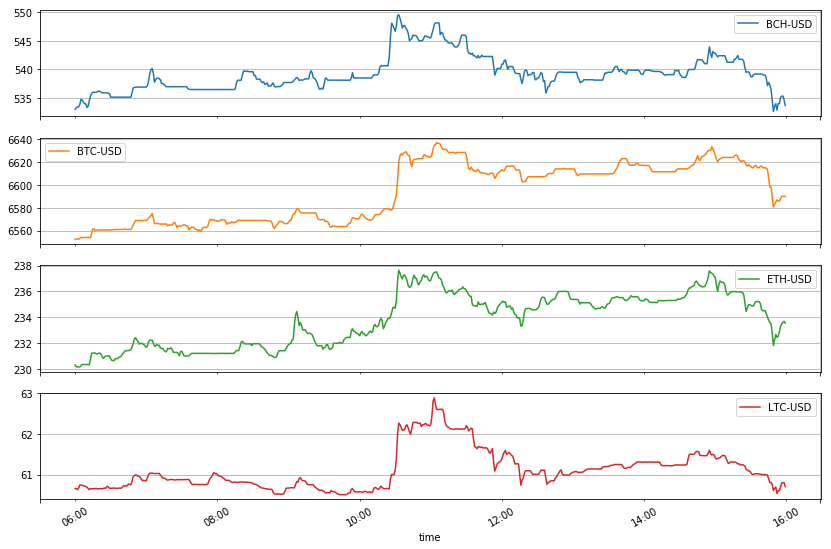

In [44]:
series_avg_copy = series_avg.copy()
series_avg_copy[keys[3]] = series_avg[keys[3]].shift(-1 * 60 * 0)
period=60*10
series_avg_copy[:period].plot(figsize=(14,10), grid=True, subplots=True)
# series_avg.corr()
series_avg_copy[:period].corr()